In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from groclient import GroClient
import groclient.utils

In [2]:
ACCESS_TOKEN = os.environ['GROAPI_TOKEN']
client = GroClient('api.gro-intelligence.com', ACCESS_TOKEN)

# Preliminary
## Defining items and metrics
In this section we are going to define everything we need to retrieve the data we want. See [Data Series Definition](https://developers.gro-intelligence.com/data-series-definition.html) for more information\
There are **3** sections\
1- Geo information - [Brazil](https://app.gro-intelligence.com/dictionary/regions/1029), province (`4`) or district (`5`) level . See [Gro Ontology](https://developers.gro-intelligence.com/gro-ontology.html) for more information\
2- Main data series - [Gro Drought Index](https://app.gro-intelligence.com/dictionary/items/17388)\
3- Crop acreage - [Soybeans](https://app.gro-intelligence.com/dictionary/items/270) [land cover](https://app.gro-intelligence.com/dictionary/metrics/2120001)

Each data point will be structured as described [here](https://developers.gro-intelligence.com/data-point-definition.html)

In [3]:
input_region = 'Brazil' # Selecting the country or region
input_level = 4 #Selecting the level of the data (granularity/resolution); 4 for province level, 5 for district level

# Data series that we want to weight
weighted_item = 'Gro Drought Index' #Item that we want to weight
weighted_metric = 'Gro Drought Index'

#Data series that we will use to compute the weighting
# For that we need the crop_id, here we use soybeans (ID = 270)
input_crop = 'soybeans'
# And a metric, so we choose `land cover (area)`, but it could very well be something else like `area harvested` or `area planted`
input_metric = 'land cover (area)'

'''Optional source selection - If not specified (None) the source will be fetched automatically'''
weighted_source = None

The [search_for_entity](https://developers.gro-intelligence.com/api.html#groclient.GroClient.search_for_entity) method allows us to convert a name (e.g. Brazil) to a Gro ID (Brazil = 1029)



In [4]:

'''Geospatial information '''
# Selecting country or region
region_id = client.search_for_entity('regions', input_region)
# Selecting the level of the data (granularity/resolution)
region_level = input_level # 4 for province level, 5 for district level
# Fetching all subregions at level `region_level`.
regions = client.get_descendant_regions(region_id, region_level, include_historical=False)
print("There are {} regions for the selected country/level".format(len(regions)))

'''Data series (drought indicator) '''
# item_id = the series we are interested in
item_id = client.search_for_entity('items', weighted_item)
# metric_id = the metric to use for our time series (here we want an index) 
metric_id = client.search_for_entity('metrics', weighted_metric)

'''Crop acreage information (to compute weights) '''
# Now that we have our time series, we want to weight it using a specific crop.
# For that we need the crop_id, here we use soybeans (ID = 270)
crop_id = client.search_for_entity('items', input_crop)
# And a metric, so we choose `land cover (area)`, but it could very well be something else like `area harvested` or `area planted`
crop_metric = client.search_for_entity('metrics', input_metric)


There are 27 regions for the selected country/level


## Data Frequency
Now that we have everything, we can select the data frequency.\
Let's look at what is `available` on the **Gro API**\
We need one for the drought index and one for the crop acreage\
Here for the **drought index** we should have either `daily` (frequency_id=1), `weekly` (frequency_id=2) or `monthly` (frequency_id=6) data.\
For the **crop acreage** it will be `point in time` (frequency_id=15) 

1. Gro Drought Index\
Three options are available: `daily`, `weekly` or `monthly`\
We can also see the information related to each available frequency below

In [5]:
series_freq = client.get_available_timefrequency(**{"region_id":region_id, "item_id":item_id, "metric_id":metric_id})
series_freq

[{'frequency_id': 1,
  'start_date': '2010-01-17T00:00:00.000Z',
  'end_date': '2021-02-07T00:00:00.000Z',
  'name': 'daily'},
 {'frequency_id': 2,
  'start_date': '2010-01-13T00:00:00.000Z',
  'end_date': '2021-02-02T00:00:00.000Z',
  'name': 'weekly'},
 {'frequency_id': 6,
  'start_date': '2010-01-01T00:00:00.000Z',
  'end_date': '2021-01-31T00:00:00.000Z',
  'name': 'monthly'}]

1. Crop Acreage\
One option is available : `point in time`

In [6]:
crop_freq = client.get_available_timefrequency(**{"region_id":region_id, "item_id":crop_id, "metric_id":crop_metric})
crop_freq

[{'frequency_id': 15,
  'start_date': '2005-12-31T00:00:00.000Z',
  'end_date': '2010-12-31T00:00:00.000Z',
  'name': 'point in time'}]

In [7]:
# We select the first frequency for each series
series_freq = series_freq[0]['frequency_id'] # This will be daily
crop_freq = crop_freq[0]['frequency_id'] # This will be point in time

## Defining necessary functions

1- `get_source` will be useful to retrieve the best `source` for our data series, from the **Gro API**. This function is derived from [rank_series_by_source](https://developers.gro-intelligence.com/api.html#groclient.GroClient.rank_series_by_source)\
2- `get_data_points_wrapper` is a wrapper around the **Gro API** [get_data_points](https://developers.gro-intelligence.com/api.html#groclient.GroClient.get_data_points) function. It will automatically fetch the best source and return the data as a DataFrame. (Source can also be specified manually)\
3- `compute_weights` will compute the `weights` from the `crop acreage` series\
4- `compute_crop_weighted_series` will compute the final output - `Crop weighted drought index`\
\
These functions can be used for any crop weighted series, no need to change anything except for the IDs defined above 

In [8]:
# We define the necessary functions
import itertools
import numpy as np

def indexOf(lst, elem, key=lambda x: x, missing_value_func=lambda x: len(x)):
    '''Returns the index of 'elem' in 'lst', or len(lst) if elem is missing'''
    return next((i for i, x in enumerate(lst) if key(x) == elem), missing_value_func(lst))

def get_source(client, queries):
    """Retrieve best source for a given level.
    Parameters
    ----------
    client : Client
        Gro Client.
    queries: List
        List of dictionaries containing Gro queries

    Returns
    -------
    Gro source id.
    """

    ranking = list(client.rank_series_by_source(queries))
    source_score = {s: 0 for s in set(dic.get("source_id") for dic in ranking)}
    
    if len(ranking) > 0:
        # Get the source ranking for each group of regions (each chunk has a ranking - so potentially multiple sources)
        # _, v -> _ is the chunk of regions (we don't explicitely need it) v is a list the dict containing the sources
        group_ranking = [
            [i['source_id'] for i in v] for _, v in itertools.groupby(ranking, lambda x: x.get('region_id'))]
        # For each group of regions increment the score value of the source by it's position in the ranking
        # Lower score is better
        for g in group_ranking:
            for s in source_score.keys():
                source_score[s] += indexOf(g, s)
        return min(source_score, key=source_score.get)
    else:
        raise exceptions.SourceDataNotAvailableError("No source available for this query")

def get_data_points_wrapper(regions, metric_id, item_id, frequency_id, source_id=None, start_date=None):        
    # Slicing our query in chunks is very useful when dealing with a lot of regions.
    # Creating queries
    queries = [{
            "metric_id": metric_id,
            "item_id": item_id,
            "start_date": start_date,
            "frequency_id": frequency_id,
            "region_id": r, } for r in groclient.utils.list_chunk(region_ids, chunk_size=200)]
    
    # Fetching source
    if source_id is None:
        source_id = get_source(client, queries)
    
    # Updating query with source
    queries = [dict({**cq, 'source_id': source_id}) for cq in queries]
    # Downloading data
    # For each query in queries, download and convert to pandas DF
    output = pd.concat(
        [pd.DataFrame().from_dict(client.get_data_points(**q)) 
         for q in queries]).reset_index(drop=True)
    output.loc[:, 'source_id'] = source_id
    return output

def compute_weights(df, regions):
    def mapper(region):
        return df[(df['region_id'] == region['id'])]['value'].mean(skipna=True)
    means = list(map(mapper, regions))
    # Normalize into weights
    total = np.nansum(means)
    if not np.isclose(total, 0.0):
        return [float(mean)/total for mean in means]
    return means

def compute_crop_weighted_series(crop_df, df, regions, weighting_func=lambda w, v: w*v):
    weights = compute_weights(crop_df, regions)
    series_list = []
    for (region, weight) in zip(regions, weights):
        series = df[(df['region_id'] == region['id'])].copy()
        series.loc[:, 'value'] = weighting_func(weight, series['value'])
        series_list.append(series)
    return pd.concat(series_list)

## Fetching data and Computing the final result

1- We fetch the two dataframes (`Gro Drought Index` and `soybeans land cover`) using the IDs and frequencies defined above\
2- We compute the `crop weighted drought index`

#### Fetching data

In [9]:
region_ids = [r['id'] for r in regions] # Get only the 'id' field for each record (region)

crop_df = get_data_points_wrapper(**{
    "regions": region_ids,
    "metric_id": crop_metric,
    "item_id": crop_id,
    "frequency_id": crop_freq,
    "source_id":None,
    "start_date": None, })

series_df = get_data_points_wrapper(**{
    "regions": region_ids,
    "metric_id": metric_id,
    "item_id": item_id,
    "frequency_id": series_freq,
    "source_id": weighted_source,
    "start_date": None, })


#### Crop weighted series

We just need to call the `compute_crop_weighted_series` function

In [10]:
crop_w_series = compute_crop_weighted_series(crop_df, series_df, regions)

In [11]:
# Displaying head and tail of the end result
crop_w_series.head(5).append(crop_w_series.tail(5))

,start_date,end_date,value,unit_id,metadata,input_unit_id,input_unit_scale,reporting_date,metric_id,item_id,region_id,partner_region_id,frequency_id,source_id
0,2010-01-17T00:00:00.000Z,2010-01-17T00:00:00.000Z,0.029023,189,{},189,1,None,15852252,17388,10402,0,1,145
1,2010-01-18T00:00:00.000Z,2010-01-18T00:00:00.000Z,0.029176,189,{},189,1,None,15852252,17388,10402,0,1,145
2,2010-01-19T00:00:00.000Z,2010-01-19T00:00:00.000Z,0.030052,189,{},189,1,None,15852252,17388,10402,0,1,145
3,2010-01-20T00:00:00.000Z,2010-01-20T00:00:00.000Z,0.030661,189,{},189,1,None,15852252,17388,10402,0,1,145
4,2010-01-21T00:00:00.000Z,2010-01-21T00:00:00.000Z,0.030128,189,{},189,1,None,15852252,17388,10402,0,1,145
108994,2021-02-03T00:00:00.000Z,2021-02-03T00:00:00.000Z,0.022060,189,{},189,1,None,15852252,17388,10428,0,1,145
108995,2021-02-04T00:00:00.000Z,2021-02-04T00:00:00.000Z,0.020724,189,{},189,1,None,15852252,17388,10428,0,1,145
108996,2021-02-05T00:00:00.000Z,2021-02-05T00:00:00.000Z,0.021033,189,{},189,1,None,15852252,17388,10428,0,1,145
108997,2021-02-06T00:00:00.000Z,2021-02-06T00:00:00.000Z,0.020414,189,{},189,1,None,15852252,17388,10428,0,1,145
108998,2021-02-07T00:00:00.000Z,2021-02-07T00:00:00.000Z,0.019828,189,{},189,1,None,15852252,17388,10428,0,1,145


#### Exporting the data as CSV

In [12]:
crop_w_series.to_csv('{}_w_{}.csv'.format(input_crop, weighted_item.replace(' ', '_').lower()), index=False)

#### Visualizing the weights (can take some time at district level)

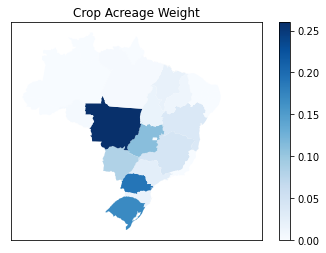

In [13]:
import geopandas
from shapely.geometry import shape
weights = compute_weights(crop_df, regions)
max_weight = max(filter(lambda x: x >0, weights))
gdf = geopandas.GeoDataFrame([{
       'region_id': region['id'], 
       'geometry': shape(client.get_geojson(region['id'])['geometries'][0]),
       'acreage_weight': weight if weight > 0 else 0
    } for (region, weight) in zip(regions, weights)])
gdf.set_index('region_id')

fig, axes = plt.subplots(1, 1)
gdf.plot(column='acreage_weight', 
         cmap='Blues', ax=axes, vmin=0, vmax=max_weight, legend=True)
axes.set_title('Crop Acreage Weight')
axes.xaxis.set_visible(False)
axes.yaxis.set_visible(False)
plt.show()

#### Visualizing drought index (non weighted vs weighted)

It is possible to change the `EVAL_DATE` variable to visualize the data at a different date

In [14]:
EVAL_DATE = u'2019-01-31T00:00:00.000Z'
gdf1 = gdf.join(series_df.set_index('region_id'), on='region_id')

cwseries_df = crop_w_series.loc[(crop_w_series.metric_id == metric_id) & \
                            (crop_w_series.end_date == EVAL_DATE), :]
gdf2 = gdf.join(cwseries_df.set_index('region_id'), on='region_id')

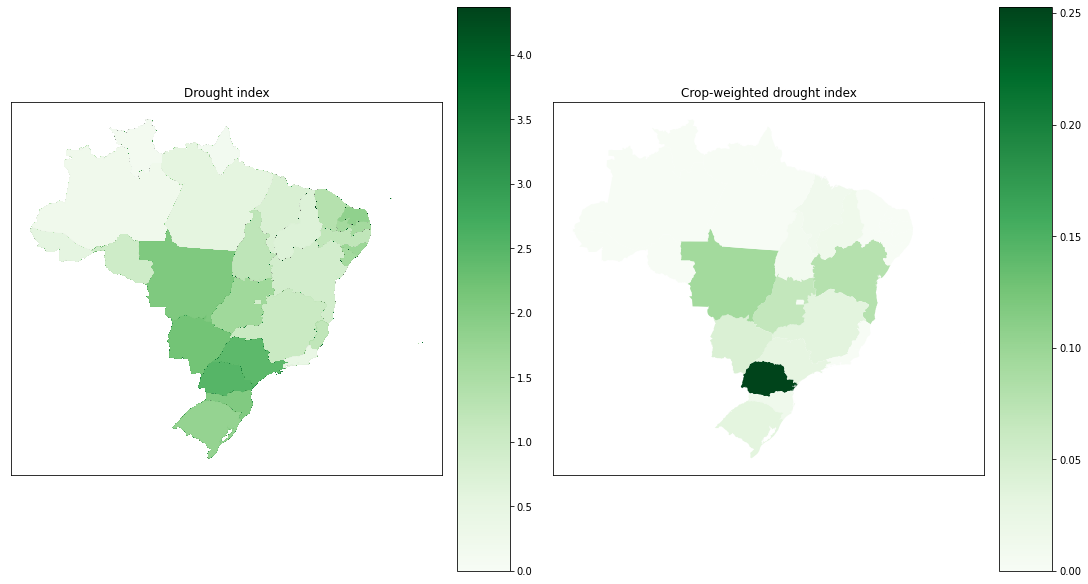

In [15]:

fig, axes = plt.subplots(1, 2, figsize=(15,8), constrained_layout=True)
gdf1.plot(column='value', 
          cmap='Greens', ax=axes[0], legend=True)
axes[0].set_title('Drought index')
axes[0].xaxis.set_visible(False)
axes[0].yaxis.set_visible(False)
gdf2.plot(column='value', 
          cmap='Greens', ax=axes[1], legend=True)
axes[1].set_title('Crop-weighted drought index')
axes[1].xaxis.set_visible(False)
axes[1].yaxis.set_visible(False)
plt.show()